# Train InfraCoder
---
Minimizing reconstruction loss while augmenting on the fly

In [1]:
# Watermark notebook - import packages
import glob, warnings, mcaap, sys, pickle, platform, multiprocessing, psutil, os, json
#-----------------------------------------------------------------------------------------------------------------#
# Command to make all plots interactive
%matplotlib ipympl
#-----------------------------------------------------------------------------------------------------------------#
# Set CPU threading before TensorFlow initializes
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"
os.environ["TF_NUM_INTEROP_THREADS"] = "8"
#-----------------------------------------------------------------------------------------------------------------#
# Import packages as
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------------------------------------------#
# ML Packages 
import tensorflow as tf
from keras.utils import *
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
#-----------------------------------------------------------------------------------------------------------------#
print(f"Python Platform: {platform.platform()}")
print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print()
print(f"Number of cores available for processing: {multiprocessing.cpu_count()}")
print(f"Total memory available: {psutil.virtual_memory().total / 1e9, 'GB'}")
print()
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU'))) # check if TensorFlow is using GPU
#-----------------------------------------------------------------------------------------------------------------#
# Ignore non-critical warnings
warnings.filterwarnings('ignore')
#-----------------------------------------------------------------------------------------------------------------#
# Load all data
X_cwt_scaled = np.load('X_cwt_scaled.npy')
X_envelope_scaled = np.load('X_envelope_scaled.npy')
X_sin_scaled = np.load('X_sin_scaled.npy')
X_cos_scaled = np.load('X_cos_scaled.npy')
print('Total inputs: '+str(X_cwt_scaled.shape[0]))
print('Scalogram dimensions: '+str(X_cwt_scaled.shape))
print('Envelope dimensions: '+str(X_envelope_scaled.shape))
print('Wavelet Phase Spectrum dimensions (sine): '+str(X_sin_scaled.shape))
print('Wavelet Phase Spectrum dimensions (cosine): '+str(X_cos_scaled.shape))

2025-11-10 15:48:04.610002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762811285.272779 1880295 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762811285.391273 1880295 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-10 15:48:06.741412: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python Platform: Linux-5.15.0-1083-nvidia-x86_64-with-glibc2.35
Tensorflow Version: 2.18.0
Keras Version: 3.8.0

Python 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]

Number of cores available for processing: 128
Total memory available: (2164.307111936, 'GB')

Num GPUs Available: 2
Total inputs: 32535
Scalogram dimensions: (32535, 64, 1200)
Envelope dimensions: (32535, 1, 1200)
Wavelet Phase Spectrum dimensions (sine): (32535, 64, 1200)
Wavelet Phase Spectrum dimensions (cosine): (32535, 64, 1200)


## Build Neural Network
---
Step 1

InfraCoder: an infrasonic phase identifier using scalograms, data envelopes, and wavelet phase spectrum

In [2]:
# Build autoencoder, embed model, and attention model
infracoder, attn_model = mcaap.build_InfraCoder(num_freq_samples=64, num_time_samples=800, lr=1e-3, l2_lambda=1e-4, return_attention=True)
infracoder.summary()

I0000 00:00:1762811622.675320 1880295 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
I0000 00:00:1762811622.677081 1880295 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79194 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Model: "Infracoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Phase_Sine    │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Phase_Cosine  │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 800,   │          0 │ Input_Phase_Sine… │
│ (Concatenate)       │ 2)                │            │ Input_Phase_Cosi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Phase       │ (None, 64, 800,   │         76 │ concatenate[0][0] │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Scalogram     │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 800,   │         16 │ Conv_1a_Phase[0]… │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Scalogram   │ (None, 64, 800,   │         40 │ Input_Scalogram[… │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 64, 800,   │          0 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 800,   │         16 │ Conv_1a_Scalogra… │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1b_Phase       │ (None, 32, 400,   │        296 │ re_lu_14[0][0]    │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 800,   │          0 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 400,   │         32 │ Conv_1b_Phase[0]… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1b_Scalogram   │ (None, 32, 400,   │        296 │ re_lu[0][0]       │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 32, 400,   │          0 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 400,   │         32 │ Conv_1b_Scalogra… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_2a_Res_Phase   │ (None, 32, 400,   │        968 │ re_lu_15[0][0]    │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 400,   │          0 │ batch_normalizat

 Total params: 198,575 (775.68 KB)

 Trainable params: 198,023 (773.53 KB)

 Non-trainable params: 552 (2.16 KB)

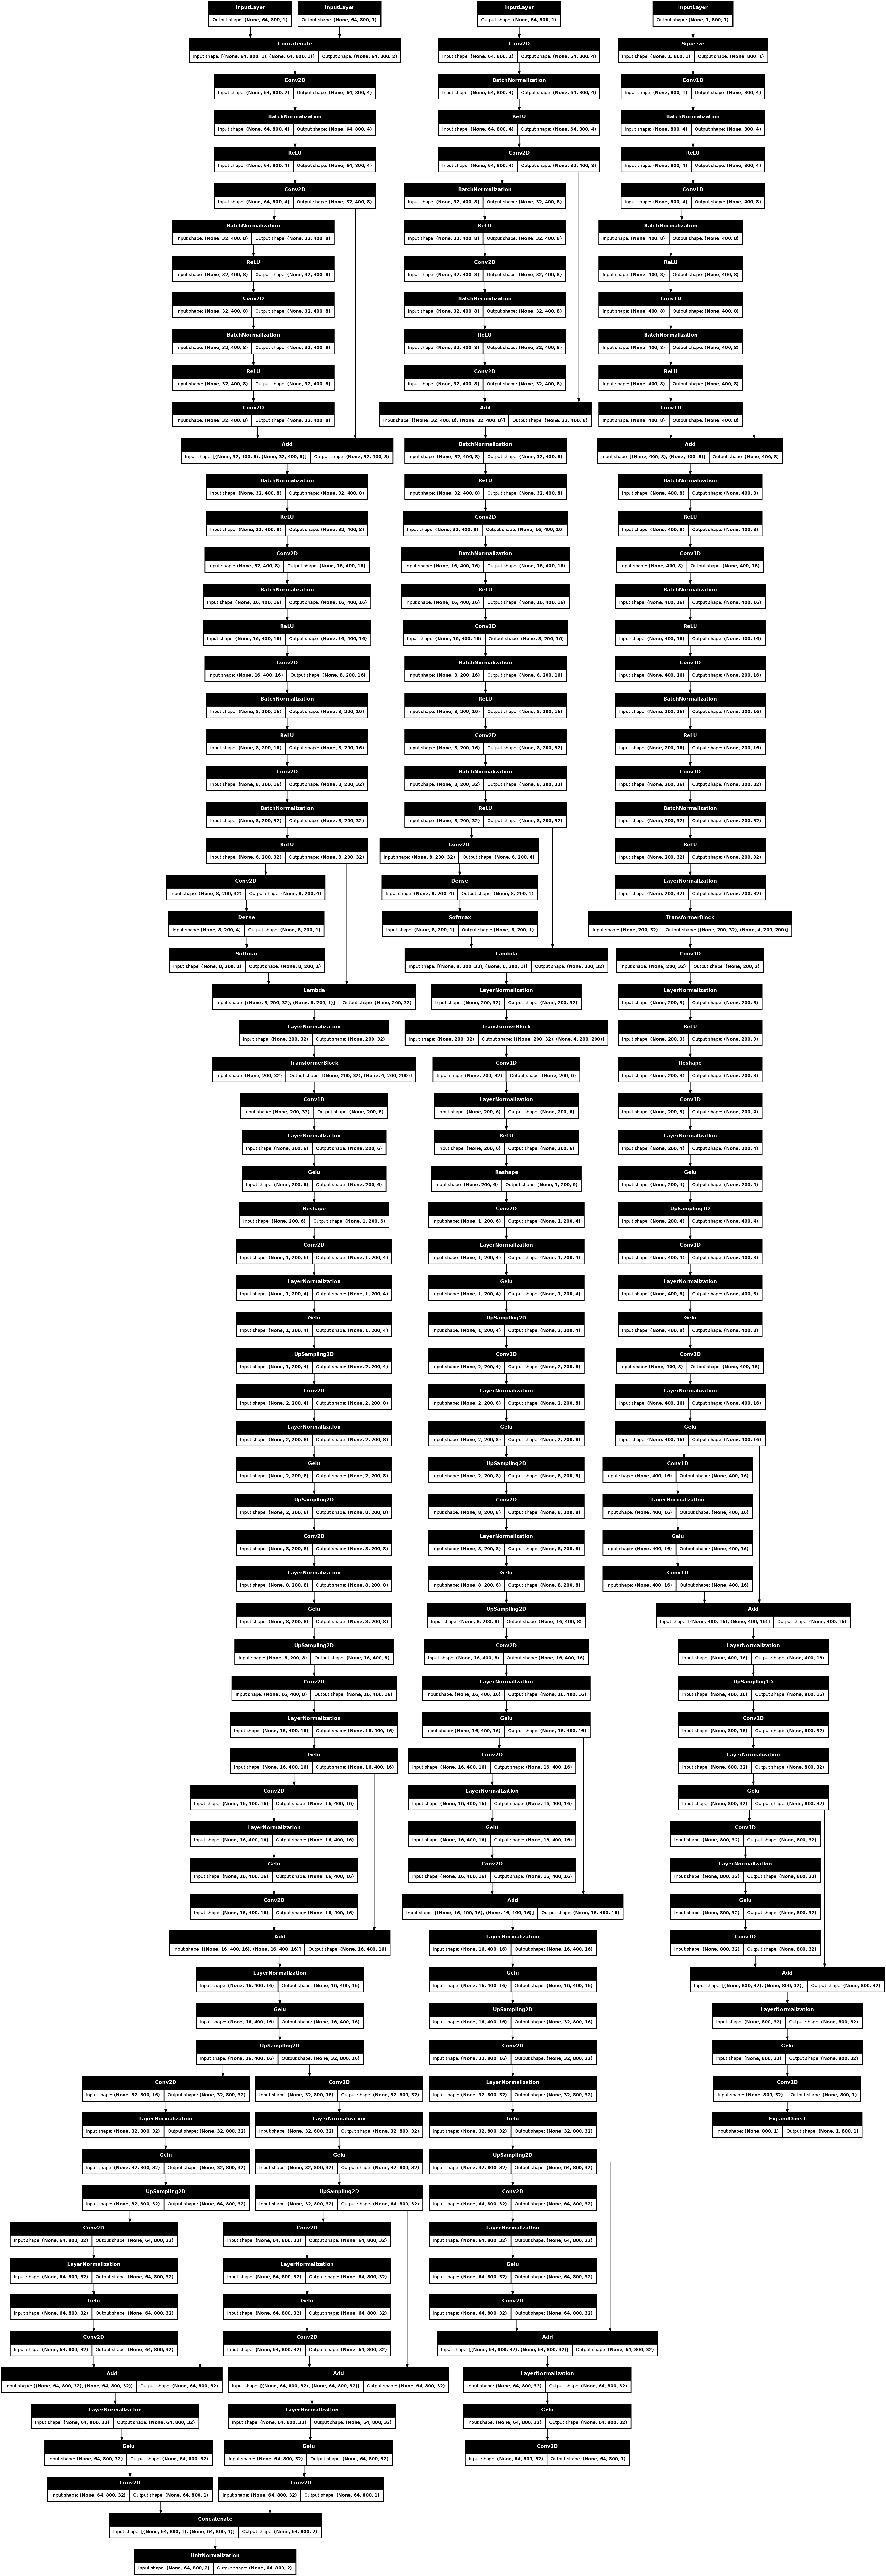

In [3]:
# Visualizing InfraCoder 
utils.plot_model(infracoder, to_file='InfraCoder.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=90)

Step 2

Initialize trimodal dataset

In [4]:
%%time
# Training params
batch_size = 64; buffer_size = X_cwt_scaled.shape[0]; steps_per_epoch = buffer_size // batch_size
#-----------------------------------------------------------------------------------------------------------------------#
# Create tensorflow datasets
scalogram_dataset = tf.data.Dataset.from_tensor_slices(X_cwt_scaled)
envelope_dataset = tf.data.Dataset.from_tensor_slices(X_envelope_scaled)
sin_dataset = tf.data.Dataset.from_tensor_slices(X_sin_scaled)
cos_dataset = tf.data.Dataset.from_tensor_slices(X_cos_scaled)
#-----------------------------------------------------------------------------------------------------------------------#
# Zip datasets together
trimodal_dataset = tf.data.Dataset.zip((scalogram_dataset, envelope_dataset, sin_dataset, cos_dataset))
#-----------------------------------------------------------------------------------------------------------------------#
# Randomly shuffle dat using buffer
trimodal_dataset = trimodal_dataset.shuffle(buffer_size=buffer_size) # Shuffle data using entire dataset
trimodal_dataset = trimodal_dataset.repeat() # Repeat dataset indefinitely, prevents dataset from running out of data when training for multiple batches
#-----------------------------------------------------------------------------------------------------------------------#
# Apply augmentation
augmented_dataset = trimodal_dataset.map(lambda x1, x2, x3, x4: mcaap.trimodal_augment_data(x1, x2, x3, x4, max_t_shift=2.5, noise_percentage=5), 
                                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
#-----------------------------------------------------------------------------------------------------------------------#
# Pack inputs/targets: stack phase channels for the phase target
def pack_io(x1, x2, x3, x4):
    # enforce static shapes if your aug loses them; adjust to your true dims
    x1 = tf.ensure_shape(x1, (64, 800, 1))  # scalogram
    x2 = tf.ensure_shape(x2, (1, 800, 1))   # envelope
    x3 = tf.ensure_shape(x3, (64, 800, 1))  # phase sin
    x4 = tf.ensure_shape(x4, (64, 800, 1))  # phase cos

    y_phase = tf.concat([x3, x4], axis=-1)  # -> (64, 800, 2)
    inputs  = (x1, x2, x3, x4)
    targets = (x1, x2, y_phase)
    return inputs, targets
augmented_dataset = augmented_dataset.map(pack_io, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#-----------------------------------------------------------------------------------------------------------------------#
# Batch data
augmented_dataset = augmented_dataset.batch(batch_size, drop_remainder=True)
#-----------------------------------------------------------------------------------------------------------------------#
# Prefetch for performance
augmented_dataset = augmented_dataset.prefetch(tf.data.AUTOTUNE)
print(augmented_dataset)

Cause: could not parse the source code of <function <lambda> at 0x1553ca8d5480>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x1553ca8d5480>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function pack_io at 0x155375589e10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function

Step 3

Train trimodal model

In [5]:
%%time
# Callbacks - Define file path for saving the model in .keras format
checkpoint_filepath = 'InfraCoder100.keras'
#-----------------------------------------------------------------------------------------------------------------------#
# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, # Filepath to save the model in .keras format
                             monitor='loss', # Metric to monitor (e.g., validation loss)
                             save_best_only=True, # Save only if the current epoch is the best
                             mode='min', # 'min' for loss (lower is better), 'max' for metrics like accuracy
                             verbose=1 # Print messages when saving
                            )
#-----------------------------------------------------------------------------------------------------------------------#
# Save training histories
csv_logger = CSVLogger('training_log.csv', append=True)

CPU times: user 16 μs, sys: 33 μs, total: 49 μs
Wall time: 54.6 μs


In [6]:
# Train
#-----------------------------------------------------------------------------------------------------------------------#
# Keep training from previous session
load_weights = False
if load_weights:
    infracoder.load_weights('InfraCoder100.keras') # model weights from last epoch
    print("Weights loaded from previous training")
#-----------------------------------------------------------------------------------------------------------------------#
# Run model.fit()
history = infracoder.fit(augmented_dataset, initial_epoch=0, epochs=100, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint, csv_logger]) # no early stopping

Epoch 1/100


I0000 00:00:1759379450.193174 3837905 service.cc:148] XLA service 0x15448c01f6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759379450.193226 3837905 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1759379450.193231 3837905 service.cc:156]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1759379450.193233 3837905 service.cc:156]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1759379450.193236 3837905 service.cc:156]   StreamExecutor device (3): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-10-01 23:30:51.248523: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759379454.517750 3837905 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-01 23:30:57.674427: I external/local_xla

508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - Output_Envelope_loss: 0.4815 - Output_Scalogram_loss: 0.5292 - Recon_Phase_loss: 0.3836 - loss: 1.3944
Epoch 1: loss improved from inf to 0.87698, saving model to InfraCoder100.keras
508/508 ━━━━━━━━━━━━━━━━━━━━ 216s 237ms/step - Output_Envelope_loss: 0.4811 - Output_Scalogram_loss: 0.5289 - Recon_Phase_loss: 0.3833 - loss: 1.3934
Epoch 2/100
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - Output_Envelope_loss: 0.0980 - Output_Scalogram_loss: 0.2591 - Recon_Phase_loss: 0.0758 - loss: 0.4330
Epoch 2: loss improved from 0.87698 to 0.40745, saving model to InfraCoder100.keras
508/508 ━━━━━━━━━━━━━━━━━━━━ 120s 237ms/step - Output_Envelope_loss: 0.0980 - Output_Scalogram_loss: 0.2591 - Recon_Phase_loss: 0.0758 - loss: 0.4329
Epoch 3/100
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - Output_Envelope_loss: 0.0815 - Output_Scalogram_loss: 0.2177 - Recon_Phase_loss: 0.0572 - loss: 0.3564
Epoch 3: loss improved from 0.40745 to 0.34341, saving model to Infr

1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2721e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0012 - loss: 0.0094
Epoch 309/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2060e-04 - Output_Phase_Cosine_loss: 0.0041 - Output_Phase_Sine_loss: 0.0040 - Output_Scalogram_loss: 0.0012 - loss: 0.0094
Epoch 309: loss improved from 0.00944 to 0.00943, saving model to InfraCoder.keras
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 406ms/step - Output_Envelope_loss: 2.2061e-04 - Output_Phase_Cosine_loss: 0.0041 - Output_Phase_Sine_loss: 0.0040 - Output_Scalogram_loss: 0.0012 - loss: 0.0094
Epoch 310/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - Output_Envelope_loss: 2.2396e-04 - Output_Phase_Cosine_loss: 0.0041 - Output_Phase_Sine_loss: 0.0040 - Output_Scalogram_loss: 0.0012 - loss: 0.0095
Epoch 310: loss did not improve from 0.00943
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 436s 415ms/step - Output_En

1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - Output_Envelope_loss: 2.1886e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0012 - loss: 0.0094
Epoch 324: loss did not improve from 0.00941
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 407ms/step - Output_Envelope_loss: 2.1886e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0012 - loss: 0.0094
Epoch 325/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2153e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0012 - loss: 0.0094
Epoch 325: loss did not improve from 0.00941
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 425s 405ms/step - Output_Envelope_loss: 2.2153e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0012 - loss: 0.0094
Epoch 326/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - Output_Envelope_loss: 2.2711e-04 - Output_Phase_C

Epoch 355/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2088e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0094
Epoch 355: loss did not improve from 0.00934
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 405ms/step - Output_Envelope_loss: 2.2088e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0094
Epoch 356/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2379e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0012 - loss: 0.0093
Epoch 356: loss did not improve from 0.00934
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 405ms/step - Output_Envelope_loss: 2.2379e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0012 - loss: 0.0093
Epoch 357/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2202e-04 -

Epoch 371/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2105e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 371: loss did not improve from 0.00932
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2105e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 372/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2178e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 372: loss did not improve from 0.00932
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 405ms/step - Output_Envelope_loss: 2.2178e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 373/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2853e-04 -

1051/1051 ━━━━━━━━━━━━━━━━━━━━ 425s 404ms/step - Output_Envelope_loss: 2.2139e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 387/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - Output_Envelope_loss: 2.2294e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 387: loss did not improve from 0.00929
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 425s 404ms/step - Output_Envelope_loss: 2.2294e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 388/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2196e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 388: loss did not improve from 0.00929
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 425s 405ms/step - Output_Envelope_loss: 2.2196e-04 - Output_Phase

Epoch 418/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - Output_Envelope_loss: 2.2091e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 418: loss did not improve from 0.00925
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 424s 404ms/step - Output_Envelope_loss: 2.2091e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 419/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - Output_Envelope_loss: 2.2395e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 419: loss did not improve from 0.00925
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 424s 403ms/step - Output_Envelope_loss: 2.2395e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 420/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - Output_Envelope_loss: 2.2172e-04 -

Epoch 434/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - Output_Envelope_loss: 2.2399e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 434: loss did not improve from 0.00922
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 431s 410ms/step - Output_Envelope_loss: 2.2398e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0039 - Output_Scalogram_loss: 0.0011 - loss: 0.0093
Epoch 435/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2365e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 435: loss did not improve from 0.00922
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2365e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 436/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.1868e-04 -

Epoch 450/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2354e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 450: loss did not improve from 0.00920
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 405ms/step - Output_Envelope_loss: 2.2354e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 451/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - Output_Envelope_loss: 2.2417e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 451: loss did not improve from 0.00920
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 428s 407ms/step - Output_Envelope_loss: 2.2417e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 452/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2051e-04 -

Epoch 466/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2157e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 466: loss did not improve from 0.00920
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2157e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 467/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - Output_Envelope_loss: 2.1608e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 467: loss improved from 0.00920 to 0.00918, saving model to InfraCoder.keras
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 428s 407ms/step - Output_Envelope_loss: 2.1609e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 468/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/ste

1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2710e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 482/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.1776e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 482: loss did not improve from 0.00917
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 406ms/step - Output_Envelope_loss: 2.1776e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 483/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2470e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 483: loss did not improve from 0.00917
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 406ms/step - Output_Envelope_loss: 2.2470e-04 - Output_Phase

Epoch 513/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - Output_Envelope_loss: 2.2035e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 513: loss did not improve from 0.00915
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 439s 417ms/step - Output_Envelope_loss: 2.2035e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 514/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - Output_Envelope_loss: 2.2450e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 514: loss did not improve from 0.00915
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 433s 412ms/step - Output_Envelope_loss: 2.2450e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 515/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - Output_Envelope_loss: 2.2120e-04 -

1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 406ms/step - Output_Envelope_loss: 2.2577e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 529/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2092e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 529: loss did not improve from 0.00912
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 405ms/step - Output_Envelope_loss: 2.2092e-04 - Output_Phase_Cosine_loss: 0.0040 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 530/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2468e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 530: loss did not improve from 0.00912
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 425s 405ms/step - Output_Envelope_loss: 2.2468e-04 - Output_Phase

Epoch 560/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2363e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 560: loss did not improve from 0.00911
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 405ms/step - Output_Envelope_loss: 2.2363e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 561/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - Output_Envelope_loss: 2.2508e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 561: loss did not improve from 0.00911
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 407ms/step - Output_Envelope_loss: 2.2508e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 562/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2140e-04 -

Epoch 576/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - Output_Envelope_loss: 2.2117e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 576: loss did not improve from 0.00910
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 433s 412ms/step - Output_Envelope_loss: 2.2117e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0092
Epoch 577/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - Output_Envelope_loss: 2.2259e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 577: loss did not improve from 0.00910
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 422s 402ms/step - Output_Envelope_loss: 2.2259e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 578/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - Output_Envelope_loss: 2.2072e-04 -

Epoch 592/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - Output_Envelope_loss: 2.2486e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 592: loss improved from 0.00909 to 0.00908, saving model to InfraCoder.keras
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 430s 409ms/step - Output_Envelope_loss: 2.2486e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 593/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.1714e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 593: loss did not improve from 0.00908
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.1714e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 594/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/ste

Epoch 608/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2639e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 608: loss did not improve from 0.00908
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2639e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 609/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2192e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0090
Epoch 609: loss did not improve from 0.00908
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2191e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0090
Epoch 610/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - Output_Envelope_loss: 2.2385e-04 -

Epoch 624/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2051e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 624: loss did not improve from 0.00906
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 425s 405ms/step - Output_Envelope_loss: 2.2051e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 625/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - Output_Envelope_loss: 2.2303e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 625: loss did not improve from 0.00906
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 425s 405ms/step - Output_Envelope_loss: 2.2303e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 626/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - Output_Envelope_loss: 2.1636e-04 -

Epoch 640/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - Output_Envelope_loss: 2.2224e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 640: loss did not improve from 0.00906
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 428s 407ms/step - Output_Envelope_loss: 2.2224e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 641/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - Output_Envelope_loss: 2.1889e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 641: loss did not improve from 0.00906
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 423s 402ms/step - Output_Envelope_loss: 2.1889e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 642/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - Output_Envelope_loss: 2.2163e-04 -

Epoch 656/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.1975e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 656: loss did not improve from 0.00904
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 406ms/step - Output_Envelope_loss: 2.1975e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 657/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2036e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0012 - loss: 0.0091
Epoch 657: loss did not improve from 0.00904
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2036e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0012 - loss: 0.0091
Epoch 658/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - Output_Envelope_loss: 2.2316e-04 -

Epoch 672/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.1878e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 672: loss did not improve from 0.00904
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 426s 406ms/step - Output_Envelope_loss: 2.1878e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 673/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - Output_Envelope_loss: 2.2508e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 673: loss did not improve from 0.00904
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 428s 407ms/step - Output_Envelope_loss: 2.2508e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 674/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2060e-04 -

Epoch 688/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.2066e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0090
Epoch 688: loss did not improve from 0.00903
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.2066e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0090
Epoch 689/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - Output_Envelope_loss: 2.1867e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 689: loss did not improve from 0.00903
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 427s 406ms/step - Output_Envelope_loss: 2.1866e-04 - Output_Phase_Cosine_loss: 0.0039 - Output_Phase_Sine_loss: 0.0038 - Output_Scalogram_loss: 0.0011 - loss: 0.0091
Epoch 690/1000
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - Output_Envelope_loss: 2.3866e-04 -

---
Rebuild and save weights for embed and attention models

In [3]:
# Try this as a simpler way to save the weights across all models
infracoder, attn_model = mcaap.build_InfraCoder(num_freq_samples=64, num_time_samples=800, lr=1e-3, l2_lambda=1e-4, return_attention=True) # rebuild graphs
infracoder.load_weights('InfraCoder100.keras') # model weights from best epoch...will be copied onto other models
#-----------------------------------------------------------------------------------------------------------------------#
# Assuming your autoencoder and attention_model have a shared encoder part (e.g., encoder layer is named "encoder")
# Chose a random layer here to make sure weights are identicaly across infracoder and embed/attention models
autoencoder_encoder_weights = infracoder.get_layer("Conv_4_Scalogram").get_weights()
attention_model_encoder_weights = attn_model.get_layer("Conv_4_Scalogram").get_weights()
#-----------------------------------------------------------------------------------------------------------------------#
# Compare the weights b/w infracoder and attn
for i, (auto_weight, attention_weight) in enumerate(zip(autoencoder_encoder_weights, attention_model_encoder_weights)):
    assert np.allclose(auto_weight, attention_weight), f"Weights mismatch at index {i}"
    print(f"Layer {i} weights are identical between infracoder and attention.")

Layer 0 weights are identical between infracoder and attention.
Layer 1 weights are identical between infracoder and attention.


In [3]:
%%time
# Now save weights for embed and attention models
attn_model.save('InfraCoder100_Attention.keras')

CPU times: user 189 ms, sys: 0 ns, total: 189 ms
Wall time: 205 ms


---
Plot training results

CPU times: user 286 ms, sys: 12 ms, total: 298 ms
Wall time: 297 ms


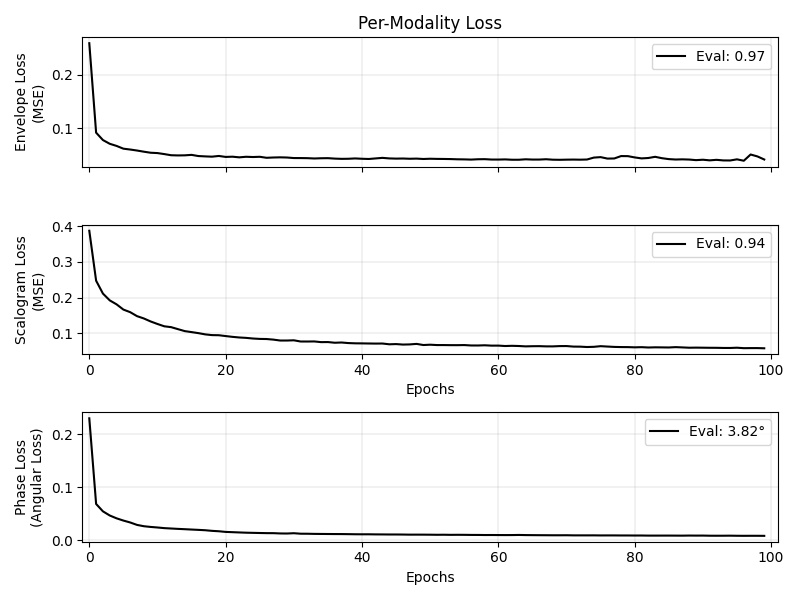

In [13]:
%%time
# Load losses per epoch
hist_file_tmp = pd.read_csv('training_log.csv')
envelope_loss = hist_file_tmp['Output_Envelope_loss'].values
scalogram_loss = hist_file_tmp['Output_Scalogram_loss'].values
phase_loss = hist_file_tmp['Recon_Phase_loss'].values
#-----------------------------------------------------------------------------------------------------------------------#
# Plot training histories
fig = plt.figure(figsize=(8,6))
#-----------------------------------------------------------------------------------------------------------------------#
# Envelope - MSE
ax1 = fig.add_subplot(3,1,1)
plt.plot(envelope_loss, color='k', label="Eval: 0.97"); plt.ylabel('Envelope Loss\n(MSE)'); plt.title('Per-Modality Loss')
plt.xlim([-1,101]); ax1.tick_params(labelbottom=False)
plt.grid(lw=0.25); plt.legend(loc="upper right")
#-----------------------------------------------------------------------------------------------------------------------#
# Scalogram - MSE
ax2 = fig.add_subplot(3,1,2, sharex=ax1)
plt.plot(scalogram_loss, color='k', label="Eval: 0.94"); plt.ylabel('Scalogram Loss\n(MSE)')
plt.xlabel('Epochs'); plt.grid(lw=0.25); plt.legend(loc="upper right")
#-----------------------------------------------------------------------------------------------------------------------#
# Phase - Angle Loss
ax3 = fig.add_subplot(3,1,3, sharex=ax1)
plt.plot(phase_loss, color='k', label="Eval: 3.82\u00b0")
plt.xlabel('Epochs'); plt.ylabel('Phase Loss\n(Angular Loss)')
plt.grid(lw=0.25); plt.legend(loc="upper right")
#-----------------------------------------------------------------------------------------------------------------------#
# Save figure
plt.tight_layout()
outpath = "Pretraining_Results.png"
fig.savefig(outpath, dpi=200, bbox_inches="tight")

In [4]:
%%time
# Evaluate each modality on the non-augmented dataset
val_ds = mcaap.build_eval_ds(X_cwt_scaled, X_envelope_scaled, X_sin_scaled, X_cos_scaled, batch_size=64) # construct raw dataset
metrics = mcaap.evaluate_offline_metrics(infracoder, val_ds)
print(metrics)

I0000 00:00:1762811761.483488 1880295 cuda_dnn.cc:529] Loaded cuDNN version 90300


{'r2_scalogram': 0.9449069417772238, 'r2_envelope': 0.9681594715439216, 'phase_mean_angle_deg': 3.8172825517831757, 'phase_mean_cos': 0.9921253481827262, 'phase_angular_loss': 0.007874651817273759}
CPU times: user 3min 20s, sys: 1min 4s, total: 4min 25s
Wall time: 2min 58s


2025-11-10 15:58:11.615275: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


---
Scrap code

In [ ]:
    # # Define Autoencoder 
    # if return_attn_for_dec == True:
    #     infracoder = Model(inputs=[input_tensor_scalogram, input_tensor_envelope, input_tensor_sin, input_tensor_cos], outputs=[decoded_scalogram, decoded_envelope, decoded_sin, decoded_cos, 
    #                                                                                                                             scalogram_attention, envelope_attention, phase_attention], 
    #                                 name='Infracoder')
    # else:
    #     infracoder = Model(inputs=[input_tensor_scalogram, input_tensor_envelope, input_tensor_sin, input_tensor_cos], outputs=[decoded_scalogram, decoded_envelope, decoded_sin, decoded_cos], 
    #                                 name='Infracoder')
    # if return_attention == True:
    #     # Create attention model only used for inference to extract attention scores (save both models after training infracoder)
    #     attention_model = Model(inputs=[input_tensor_scalogram, input_tensor_envelope, input_tensor_sin, input_tensor_cos], outputs=[scalogram_attention, envelope_attention, phase_attention], 
    #                                     name='Attention_Model')
    #     infracoder.compile(optimizer=adam, loss=tf.keras.losses.MeanSquaredError())
    #     return infracoder, attention_model
    # else:
    #     infracoder.compile(optimizer=adam, loss=tf.keras.losses.MeanSquaredError())
    #     return infracoder

In [ ]:
# %%time
# # Assuming your prefetched dataset outputs (x1, x2, x3, x4) as inputs
# augmented_dataset = augmented_dataset.map(lambda x1, x2, x3, x4: ((x1, x2, x3, x4), (x1, x2, x3, x4), (x1, x2, x3, x4)))
# #-----------------------------------------------------------------------------------------------------------------------#
# # Check the structure of a batch
# for batch in augmented_dataset.take(1):
#     print("Batch input shapes:", [x.shape for x in batch[0]])  # Inputs
#     print("Batch target shapes:", [y.shape for y in batch[1]])  # Targets (should match inputs)

In [ ]:
# %%time
# # Check for nan or inf values in dataset
# mcaap.check_dataset_for_nan_inf(scalogram_dataset, "Scalogram dataset")
# mcaap.check_dataset_for_nan_inf(envelope_dataset, "Envelope dataset")
# mcaap.check_dataset_for_nan_inf(sin_dataset, "Phase Sine dataset")
# mcaap.check_dataset_for_nan_inf(cos_dataset, "Phase Cosine dataset")

In [20]:
%%time
# Save attention model (weights won't be correct since InfraCoder restores best weights from different epoch)
attn_model.save('SPT_AE/InfraCoder100_Attention.keras')

CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 156 ms


---
Sanity check: need to make sure attention model weights match infracoder weights

In [21]:
# Path to the saved model (ensure the path points to your .keras model file)
model_path = "SPT_AE/InfraCoder100_Attention.keras"

# To allow unsafe deserialization (if you trust the model source)
tf.keras.config.enable_unsafe_deserialization()

# Load the model
attn_model = tf.keras.models.load_model(model_path, custom_objects={'TransformerBlock': mcaap.TransformerBlock}, compile=False)

# Check the model summary to verify it's loaded correctly
attn_model.summary()

Model: "Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Phase_Sine    │ (None, 20, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Phase_Cosine  │ (None, 20, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Scalogram     │ (None, 20, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Envelope      │ (None, 1, 800, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Phase_Sine  │ (None, 20, 800,   │         40 │ Input_Phase_Sine… │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Phase_Cosi… │ (None, 20, 800,   │         40 │ Input_Phase_Cosi… │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Scalogram   │ (None, 20, 800,   │         40 │ Input_Scalogram[… │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_12          │ (None, 800, 1)    │          0 │ Input_Envelope[0… │
│ (Squeeze)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20, 800,   │          0 │ Conv_1a_Phase_Si… │
│ (Concatenate)       │ 8)                │            │ Conv_1a_Phase_Co… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 800,   │         16 │ Conv_1a_Scalogra… │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Hilbert     │ (None, 800, 4)    │         16 │ squeeze_12[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 800,   │         32 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 20, 800,   │          0 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 4)    │         16 │ Conv_1a_Hilbert[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 20, 800,   │          0 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1b_Stride_Sca… │ (None, 20, 400,   │        808 │ re_lu_23[0][0]    │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 800, 4)    │          0 │ batch_normalizat

 Total params: 105,312 (411.38 KB)

 Trainable params: 104,656 (408.81 KB)

 Non-trainable params: 656 (2.56 KB)

In [22]:
# Path to the saved model (ensure the path points to your .keras model file)
model_path = "SPT_AE/InfraCoder100.keras"

# To allow unsafe deserialization (if you trust the model source)
tf.keras.config.enable_unsafe_deserialization()

# Load the model
infracoder = tf.keras.models.load_model(model_path, custom_objects={'TransformerBlock': mcaap.TransformerBlock}, compile=False)

# Check the model summary to verify it's loaded correctly
infracoder.summary()

Model: "Infracoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Phase_Sine    │ (None, 20, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Phase_Cosine  │ (None, 20, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Scalogram     │ (None, 20, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Envelope      │ (None, 1, 800, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Phase_Sine  │ (None, 20, 800,   │         40 │ Input_Phase_Sine… │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Phase_Cosi… │ (None, 20, 800,   │         40 │ Input_Phase_Cosi… │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Scalogram   │ (None, 20, 800,   │         40 │ Input_Scalogram[… │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_15          │ (None, 800, 1)    │          0 │ Input_Envelope[0… │
│ (Squeeze)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20, 800,   │          0 │ Conv_1a_Phase_Si… │
│ (Concatenate)       │ 8)                │            │ Conv_1a_Phase_Co… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 800,   │         16 │ Conv_1a_Scalogra… │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Hilbert     │ (None, 800, 4)    │         16 │ squeeze_15[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 800,   │         32 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 20, 800,   │          0 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 4)    │         16 │ Conv_1a_Hilbert[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 20, 800,   │          0 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1b_Stride_Sca… │ (None, 20, 400,   │        808 │ re_lu_23[0][0]    │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 800, 4)    │          0 │ batch_normalizat

 Total params: 170,384 (665.56 KB)

 Trainable params: 169,728 (663.00 KB)

 Non-trainable params: 656 (2.56 KB)

In [23]:
%%time
def copy_weights_by_name(src_model, dst_model, verbose=True):
    copied, skipped = 0, 0
    for dst in dst_model.layers:
        # skip layers with no weights (InputLayer, reshapes, activations, etc.)
        if not dst.weights:
            if verbose: print(f"skip {dst.name}: no weights")
            continue
        # find same-named layer in source
        try:
            src = src_model.get_layer(dst.name)
        except ValueError:
            if verbose: print(f"skip {dst.name}: not found in source")
            skipped += 1
            continue
        sw, dw = src.get_weights(), dst.get_weights()
        # ensure same number/shape of tensors
        if len(sw) != len(dw) or any(s.shape != d.shape for s, d in zip(sw, dw)):
            if verbose:
                print(f"skip {dst.name}: shape mismatch "
                      f"{[s.shape for s in sw]} vs {[d.shape for d in dw]}")
            skipped += 1
            continue
        dst.set_weights(sw)
        if verbose: print(f"copied {dst.name}")
        copied += 1
    if verbose: print(f"Copied {copied} layers; skipped {skipped}")

# usage
copy_weights_by_name(infracoder, attn_model)

skip Input_Phase_Sine: no weights
skip Input_Phase_Cosine: no weights
skip Input_Scalogram: no weights
skip Input_Envelope: no weights
copied Conv_1a_Phase_Sine
copied Conv_1a_Phase_Cosine
copied Conv_1a_Scalogram
skip concatenate_1: no weights
copied batch_normalization_21
copied Conv_1a_Hilbert
copied batch_normalization_35
copied batch_normalization_28
copied Conv_1b_Stride_Scalogram
copied Conv_1b_Stride_Phase_Sine
copied batch_normalization_22
copied Conv_1b_Hilbert
copied batch_normalization_36
copied batch_normalization_29
copied Conv_2a_Res_Scalogram
copied Conv_2a_Res_Phase
copied batch_normalization_23
copied Conv_2a_Res_Hilbert
copied batch_normalization_37
copied batch_normalization_30
copied Conv_2b_Res_Scalogram
copied Conv_1b_Res_Phase
skip add_6: no weights
copied Conv_2b_Res_Hilbert
skip add_8: no weights
copied batch_normalization_24
skip add_7: no weights
copied batch_normalization_38
copied batch_normalization_31
copied Conv_3_Stride_Scalogram
copied Conv_3_Stride_P

In [24]:
# Assuming your autoencoder and attention_model have a shared encoder part (e.g., encoder layer is named "encoder")
# Chose a random layer here to make sure weights are identicaly across infracoder and infracoder attention model
autoencoder_encoder_weights = infracoder.get_layer("Conv_4b_Scalogram").get_weights()
attention_model_encoder_weights = attn_model.get_layer("Conv_4b_Scalogram").get_weights()

# Compare the weights
for i, (auto_weight, attention_weight) in enumerate(zip(autoencoder_encoder_weights, attention_model_encoder_weights)):
    assert np.allclose(auto_weight, attention_weight), f"Weights mismatch at index {i}"
    print(f"Layer {i} weights are identical.")

Layer 0 weights are identical.
Layer 1 weights are identical.


In [25]:
%%time
# Saving the attention model
attn_model.save('SPT_AE/InfraCoder100_Attention.keras')

CPU times: user 158 ms, sys: 260 μs, total: 158 ms
Wall time: 155 ms


---
Plot results

In [9]:
pd.read_csv('SPT_AE/training_log.csv')

,epoch,Output_Envelope_loss,Output_Envelope_r2_batch,Output_Scalogram_loss,Output_Scalogram_r2_batch,Recon_Phase_loss,Recon_Phase_phase_mean_angle_deg,loss,val_Output_Envelope_loss,val_Output_Envelope_r2_batch,val_Output_Scalogram_loss,val_Output_Scalogram_r2_batch,val_Recon_Phase_loss,val_Recon_Phase_phase_mean_angle_deg,val_loss
0,0,0.012015,-0.563859,0.032652,-2.978621,0.140953,27.638855,0.115962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.002669,0.759728,0.007513,0.076455,0.139973,27.566969,0.080562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.002396,0.794727,0.005512,0.316112,0.139925,27.564020,0.078030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.002220,0.815694,0.004830,0.398815,0.139926,27.563923,0.077122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.002138,0.825331,0.004570,0.428665,0.139918,27.562807,0.076779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,0.002063,0.833107,0.004343,0.456485,0.139918,27.562559,0.076489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,0.002033,0.836427,0.004273,0.464597,0.139916,27.562378,0.076392,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,0.002006,0.839292,0.004231,0.468557,0.139916,27.562408,0.076320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,0.001980,0.842113,0.004075,0.487553,0.139917,27.562428,0.076125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,0.001798,0.855748,0.004017,0.494881,0.139916,27.562330,0.075911,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
%%time
# Load and compute variances
hist_file_tmp = pd.read_csv('SPT_AE/training_log.csv')
target_envelope = np.var(X_envelope_scaled)
target_scalogram = np.var(X_cwt_scaled)
#-----------------------------------------------------------------------------------------------------------------------#
# Compute R²
r2_envelope = 1 - (hist_file_tmp['Output_Envelope_loss'] / target_envelope)
r2_scalogram = 1 - (hist_file_tmp['Output_Scalogram_loss'] / target_scalogram)
phase_mean_angle_deg = hist_file_tmp['Recon_Phase_phase_mean_angle_deg']

CPU times: user 1.03 s, sys: 359 ms, total: 1.38 s
Wall time: 1.38 s


Text(0.5, 0.98, 'InfraCoder')

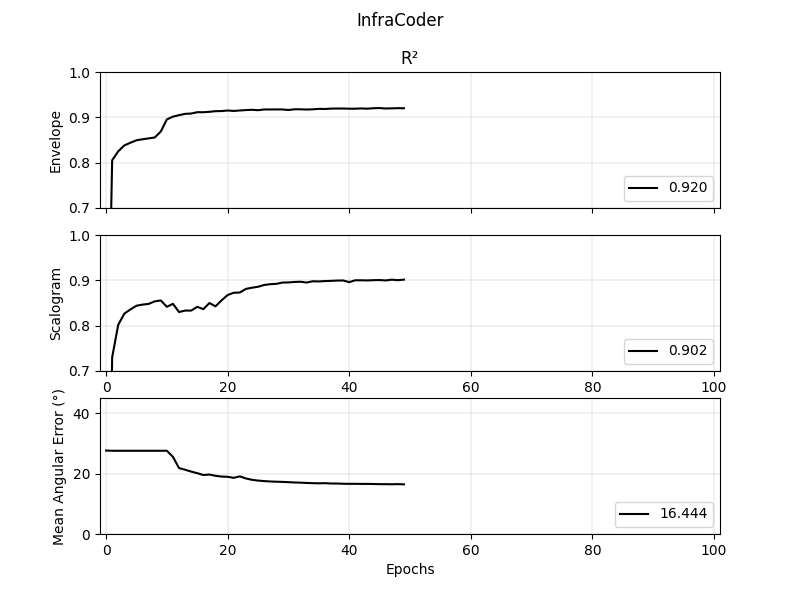

In [18]:
# Plot training histories
fig = plt.figure(figsize=(8,6))
#-----------------------------------------------------------------------------------------------------------------------#
# Envelope - R²
ax1 = fig.add_subplot(3,1,1)
plt.plot(r2_envelope, color='k'); plt.ylabel('Envelope'); plt.title('R²')
plt.xlim([-1,101]); plt.ylim([0.7, 1]); ax1.tick_params(labelbottom=False)
plt.legend(['%.3f'%np.array(r2_envelope).max()], loc='lower right', prop = { "size": 10})
plt.grid(lw=0.25)
#-----------------------------------------------------------------------------------------------------------------------#
# Scalogram - R²
ax2 = fig.add_subplot(3,1,2, sharex=ax1, sharey=ax1)
plt.plot(r2_scalogram, color='k'); plt.ylabel('Scalogram')
plt.legend(['%.3f'%np.array(r2_scalogram).max()], loc='lower right', prop = { "size": 10})
plt.xlabel('Epochs'); plt.grid(lw=0.25)
#-----------------------------------------------------------------------------------------------------------------------#
# Phase - Mean Angular Error
ax3 = fig.add_subplot(3,1,3, sharex=ax1)
plt.plot(phase_mean_angle_deg, color='k'); plt.ylim([0,45])
plt.xlabel('Epochs'); plt.ylabel('Mean Angular Error (\u00b0)')
plt.legend(['%.3f'%np.array(phase_mean_angle_deg).min()], loc='lower right', prop = { "size": 10})
plt.grid(lw=0.25)
#-----------------------------------------------------------------------------------------------------------------------#
# Title
plt.suptitle('InfraCoder')